### 0. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

os.chdir("../")
from scripts import utils
from pathlib import Path
import matplotlib.gridspec as gridspec
from tqdm.auto import tqdm

In [2]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
from mlxtend.evaluate import feature_importance_permutation
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.utils.estimator_checks import check_estimator
from mlxtend.feature_selection import (
    SequentialFeatureSelector,
)
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import matplotlib.ticker as ticker
import distclassipy as dcpy

In [4]:
epsilon = np.finfo(np.float32).eps

In [5]:
with open("settings.txt") as f:
    settings_dict = json.load(f)
seed_val = settings_dict["seed_choice"]
np.random.seed(seed_val)
sns_dict = settings_dict["sns_dict"]
sns.set_theme(**sns_dict)

In [6]:
# unique_metrics = [
#     "euclidean",
#     "braycurtis",
#     "canberra",
#     "cityblock",
#     "chebyshev",
#     "clark",
#     "correlation",
#     "cosine",
#     "hellinger",
#     "jaccard",
#     "lorentzian",
#     # "marylandbridge",
#     "meehl",
#     "soergel",
#     "wave_hedges",
#     "kulczynski",
#     "add_chisq",
#     "acc",
#     "chebyshev_min",
#     "dice",
#     "divergence",
#     "google",
#     "jeffreys",
#     "kumarjohnson",
#     "penroseshape",
#     "squared_chisq",
#     "squaredchord",
#     "squared_euclidean",
#     "taneja",
#     "topsoe",
#     "vicis_symmetric_chisq",
#     "vicis_wave_hedges",
# ]

unique_metrics = ['euclidean',
 'braycurtis',
 'canberra',
 'cityblock',
 'chebyshev',
 'clark',
 'correlation',
 'cosine',
 'hellinger',
 'jaccard',
 'lorentzian',
 # 'marylandbridge',
 'meehl',
 'motyka',
 'soergel',
 'wave_hedges',
 'kulczynski',
 # 'add_chisq'
                 ]


final_features = [
    "SPM_A_Y",
    "Multiband_period",
    "r-i",
    "Harmonics_phase_4_i",
    "Harmonics_phase_2_r",
    "Power_rate_4",
]

In [7]:
features = pd.read_parquet("data/reduced_balancedfeatures_LATEST.parquet")
features["class"].value_counts()

class
CEP     683
DSCT    683
EB      683
RRL     683
Name: count, dtype: int64

In [8]:
features = features.sample(frac=1)

In [9]:
y_normal_df = features["class"]
# X_df = features.drop(["Coordinate_x", "Coordinate_y", "Coordinate_z", "class"], axis=1)
X_normal_df = features.loc[:, final_features]

In [10]:
other_features_df = pd.read_parquet("data/otherclassobjs_features.parquet")
other_features_df.index.name = "snid"
other_lc_df = pd.read_parquet("data/otherclassobjs.parquet")
other_lc_df.index.name = "snid"

other_lc_df=other_lc_df[~other_lc_df["class"].isin(['d-Sct', 'Cepheid', 'EB', 'RRL'])]
other_features_df=other_features_df.loc[other_lc_df.index]


other_lc_df = other_lc_df.loc[other_features_df.index]

assert (other_lc_df.index == other_features_df.index).all()

In [11]:
X_anom_df = other_features_df.loc[:, X_normal_df.columns].dropna()
X_anom_df = X_anom_df.drop(np.intersect1d(X_anom_df.index, X_normal_df.index))
y_anom_df = other_lc_df.loc[X_anom_df.index]["class"]
X_anom_df=X_anom_df.loc[y_anom_df.index]

In [12]:
X_df = pd.concat([X_normal_df, X_anom_df])
y_df = pd.concat([y_normal_df, y_anom_df])

In [13]:
assert (X_df.index == y_df.index).all()

### 1. Isolation Forest

In [14]:
from sklearn.ensemble import IsolationForest
from scipy import stats

In [15]:
def runif(random_state, X_traindf, X_testdf):
    clf = IsolationForest(
        max_samples=10, contamination="auto", random_state=random_state
    )
    clf.fit(X_traindf)  # , sample_weight=1.0/(Xfixed[:,2,:])**2)
    scores_pred_Norm = clf.decision_function(X_testdf)
    # scores_pred_Norm = clf.score_samples(X)
    # .sample_score(X)

    threshold_Norm = stats.scoreatpercentile(scores_pred_Norm, 100 * 0.1)
    #y_predNorm = clf.predict(X)
    abornmality = -scores_pred_Norm
    iforest_df = pd.DataFrame(
        abornmality, columns=["abnormality"], index=X_testdf.index,
    )  # higher is more abnormal
    # iforest_df.index.name = "sample_num"
    # iforest_df = iforest_df.sort_values(by="abnormality", ascending=False)
    return iforest_df.index, iforest_df

In [16]:
ranksIF = []
ranksIDdfs = []
ifseeds = np.random.randint(100, 1000, 3)
for i in ifseeds:
    _ = runif(i, X_traindf=X_normal_df, X_testdf=X_df)
    ranksIF.append(_[0])
    ranksIDdfs.append(_[1])
ranksIF

[Index([ 93852051, 133953454, 156704754,  94869465, 143158599,  97209193,
        118286557, 145870285, 107197896,  34324163,
        ...
         85155628,  35432717,  89686555, 132925610, 135470168,  69018019,
         97601275,  97897233, 130127663,  90121628],
       dtype='int64', name='snid', length=4318),
 Index([ 93852051, 133953454, 156704754,  94869465, 143158599,  97209193,
        118286557, 145870285, 107197896,  34324163,
        ...
         85155628,  35432717,  89686555, 132925610, 135470168,  69018019,
         97601275,  97897233, 130127663,  90121628],
       dtype='int64', name='snid', length=4318),
 Index([ 93852051, 133953454, 156704754,  94869465, 143158599,  97209193,
        118286557, 145870285, 107197896,  34324163,
        ...
         85155628,  35432717,  89686555, 132925610, 135470168,  69018019,
         97601275,  97897233, 130127663,  90121628],
       dtype='int64', name='snid', length=4318)]

# Sid note: the below needs fixing. I changed above such that rankIDdf isn't sorted when it's sent back; fix later

/var/folders/2d/ht34x6mn7hx9d1sv4g_j8nfr0000gn/T/ipykernel_98234/2281571738.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(


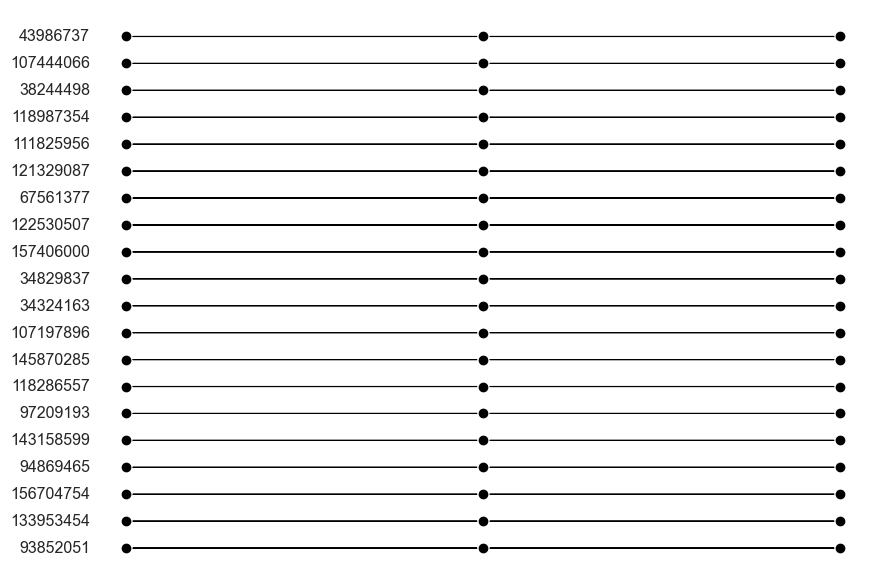

In [17]:
def plotstuff(list_a, list_b, i, ax, arrow_len=0.1):
    # Plot the two columns of equidistant points
    a = list(list_a)
    b = list(list_b)
    a_to_b_indices = [b.index(x) + 1 if x in b else None for x in a]
    for j, target_index in enumerate(a_to_b_indices):
        if target_index is not None:
            ax.arrow(
                0.02 + i,
                j + 1,
                0.96,
                target_index - (j + 1),
                # head_width=0.05 * arrow_len * 10, head_length=0.1 * arrow_len * 10,
                fc="black",
                ec="black",
                length_includes_head=False,
            )


def plot_ranks(rankslists, nsamples=10, labels_offset=0.1):
    """
    Plots two columns of points representing two lists (a and b)
    and draws arrows connecting the rank of elements in 'a' to
    their corresponding position in 'b'.

    Args:
        a (list): The first list of elements.
        b (list): The second list of elements.
        labels_offset (float, optional): Offset for the text labels. Defaults to 0.1.
        arrow_len (float, optional): Length of the arrows. Defaults to 0.1.
    """
    n_items = nsamples
    fig, ax = plt.subplots(
        figsize=(3 * len(rankslists), n_items * 0.3)
    )  # Adjust figure size

    for i in range(len(rankslists)):
        if i == 0:
            a = rankslists[i][:nsamples]
            ax.plot(
                np.ones(n_items),
                np.arange(1, n_items + 1),
                "o",
                markersize=6,
                color="black",
            )
            for j, val in enumerate(a):
                ax.text(1 - labels_offset, j + 1, str(val), ha="right", va="center")
        else:
            b = rankslists[i][:nsamples]
            a = rankslists[i - 1][:nsamples]
            ax.plot(
                np.full(n_items, i + 1),
                np.arange(1, n_items + 1),
                "ro",
                markersize=6,
                color="black",
            )
            for j, val in enumerate(b):
                if not val in b:
                    ax.text(
                        1 - labels_offset + i, j + 1, str(val), ha="right", va="center"
                    )
            plotstuff(a, b, i, ax)

        # Remove axes and labels
        # ax.set_xlim(0, 3)
    ax.set_ylim(0, n_items + 1)
    ax.axis("off")
    plt.tight_layout()

    plt.show()


plot_ranks(ranksIF, nsamples=20)

In [18]:
df=pd.concat(ranksIDdfs,axis=1)
df.columns = ["if1", "if2", "if3"]
df = df.sort_values(by="if2",ascending=False)
for c in df.columns:
    df["quartile_" + c] = pd.qcut(df[c], q=4, labels=False)  # Divides into 4 quantiles
df

,if1,if2,if3,quartile_if1,quartile_if2,quartile_if3
snid,,,,,,
96837672,0.153602,0.155124,0.154811,3,3,3
34882116,0.140443,0.153602,0.150165,3,3,3
94602724,0.151189,0.152706,0.151189,3,3,3
92717442,0.142569,0.149095,0.140373,3,3,3
125103424,0.144949,0.147896,0.131143,3,3,3
...,...,...,...,...,...,...
25574309,-0.081332,-0.080189,-0.085043,0,0,0
53358169,-0.069479,-0.081257,-0.069940,0,0,0
1283805,-0.074399,-0.081578,-0.071600,0,0,0


In [19]:
df["class"] = y_df.loc[df.index]

In [20]:
df.iloc[:20]

,if1,if2,if3,quartile_if1,quartile_if2,quartile_if3,class
snid,,,,,,,
96837672,0.153602,0.155124,0.154811,3,3,3,CEP
34882116,0.140443,0.153602,0.150165,3,3,3,CEP
94602724,0.151189,0.152706,0.151189,3,3,3,CEP
92717442,0.142569,0.149095,0.140373,3,3,3,CEP
125103424,0.144949,0.147896,0.131143,3,3,3,CEP
83406315,0.128089,0.143122,0.129563,3,3,3,CEP
132356710,0.118630,0.141934,0.109123,3,3,3,CEP
59245585,0.123838,0.140197,0.134723,3,3,3,CEP
108559610,0.117724,0.138254,0.141980,3,3,3,CEP


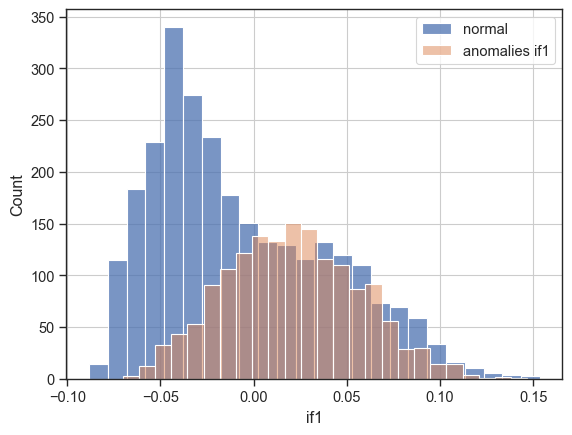

In [21]:
sns.histplot(df[df["class"].isin(["CEP",
"DSCT",
"EB",
"RRL",]
)]["if1"], label="normal")

sns.histplot(df[~df["class"].isin(["CEP",
"DSCT",
"EB",
"RRL",]
)]["if1"], label="anomalies if1", alpha=0.5)
    
plt.legend()
plt.show()

## SAME BINS

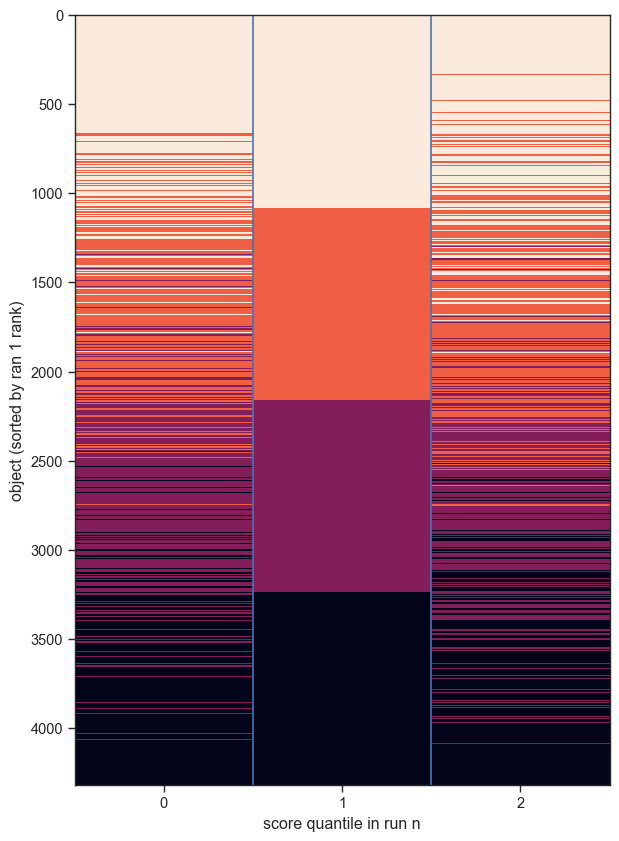

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(df[["quartile_if1", "quartile_if2", "quartile_if3"]], interpolation="none")
ax.set_aspect(0.001)
ax.set_xlabel("score quantile in run n")
ax.set_xticks(range(len(df.columns) - 3-1))
ax.set_ylabel("object (sorted by ran 1 rank)")
plt.grid(None)
ax.axvline(0.5)
ax.axvline(1.5)

In [23]:
top_quantile = df[df["quartile_if1"] == df["quartile_if1"].max()][["quartile_if1", "quartile_if2", "quartile_if3"]]
print(
    f'fraction of run2 top quantile in run 1 {(top_quantile["quartile_if1"] == top_quantile["quartile_if2"]).sum() / top_quantile.shape[0]}'
)
print(
    f'fraction of run3 top quantile in run 1 {(top_quantile["quartile_if1"] == top_quantile["quartile_if3"]).sum() / top_quantile.shape[0]}'
)

fraction of run2 top quantile in run 1 0.8527777777777777
fraction of run3 top quantile in run 1 0.8490740740740741


### Distances

In [24]:
lcdc = dcpy.DistanceMetricClassifier(
    scale=True,
    central_stat="median",
    dispersion_stat="std",
)
lcdc.fit(X_normal_df, y_normal_df)

DistanceMetricClassifier()

In [25]:
dist_df_dict = {}
for metric in tqdm(unique_metrics, desc="Metric", leave=True):
    metric_str = utils.get_metric_name(metric)
    _ = lcdc.predict_and_analyse(X_df, metric=metric)

    dist_df = lcdc.centroid_dist_df_

    dist_df["minimum_distance"] = dist_df.min(axis=1)
    dist_df["median_distance"] = dist_df.median(axis=1)

    dist_df_dict[metric_str] = dist_df

Metric:   0%|          | 0/16 [00:00<?, ?it/s]

In [26]:
n_metrics = len(unique_metrics)
clusters = np.unique(y_normal_df)
n_clusters = len(clusters)
n_objects = dist_df.shape[0]


print(f"n: {n_objects=}")
print(f"m: {n_metrics=}")
print(f"k: {n_clusters=}")

n: n_objects=4318
m: n_metrics=16
k: n_clusters=4


In [27]:
dist_df_arr = np.zeros((n_objects, n_clusters, n_metrics))
for i in range(n_objects):
    for j, cluster in enumerate(clusters):
        for k, metric in enumerate(unique_metrics):
            metric_str = utils.get_metric_name(metric)
            dist_df_arr[i, j, k] = dist_df_dict[metric_str].loc[i, f"{cluster}_dist"]

In [28]:
from sklearn.preprocessing import minmax_scale
scaled_data = np.empty_like(dist_df_arr)

# Min-Max Scaling
for i in range(len(unique_metrics)):
  scaled_data[:,:,i] = minmax_scale(dist_df_arr[:,:,i], feature_range=(epsilon, 1), axis=1)

scaled_dist_df_dict = {}
for i,m in enumerate(unique_metrics):
  m = utils.get_metric_name(m)
  scaled_dist_df_dict[m] = pd.DataFrame(scaled_data[:,:,i], columns = dist_df_dict[m].columns[:-2], index=dist_df_dict[m].index)

In [29]:
scaled_dist_df_arr = np.zeros((n_objects, n_clusters, n_metrics))
for i in range(n_objects):
    for j, cluster in enumerate(clusters):
        for k, metric in enumerate(unique_metrics):
            metric_str = utils.get_metric_name(metric)
            scaled_dist_df_arr[i, j, k] = scaled_dist_df_dict[metric_str].loc[i,f"{cluster}_dist"]

In [30]:
## DELETE?

np.array(unique_metrics)[np.where((dist_df_arr < 0).sum(axis=1).sum(axis=0)>0)[0]]

array([], dtype='<U11')

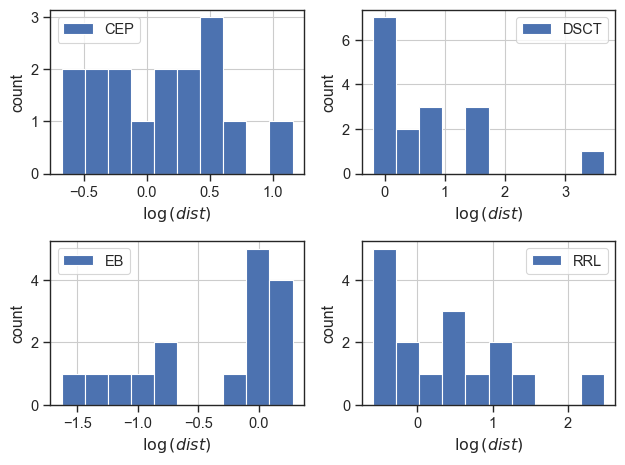

In [31]:
## DELETE?

np.random.seed(302)
objnum = np.random.randint(1000)
# one cluster each plot
# all distance metrics in each plot

fig, ax = plt.subplots(2,2)
axs = ax.ravel()
for j, cluster in enumerate(clusters):
    axs[j].hist(np.log10(dist_df_arr[objnum,j,:]), label=cluster)
    # axs[j].set_xscale("log")
    axs[j].legend()
    axs[j].set_xlabel(r"$\log{(dist)}$")
    axs[j].set_ylabel("count")
plt.tight_layout()
plt.show()

In [32]:
## DELETE?

# #remove negative metrics from the array
# dist_df_arr = dist_df_arr[:,:,[i for i in range(dist_df_arr.shape[-1]) if not i in np.where((dist_df_arr < 0).sum(axis=1).sum(axis=0)>0)[0]]]
# np.array(all_metrics)[np.where((dist_df_arr < 0).sum(axis=1).sum(axis=0)>0)[0]]
# dist_df_arr.shape

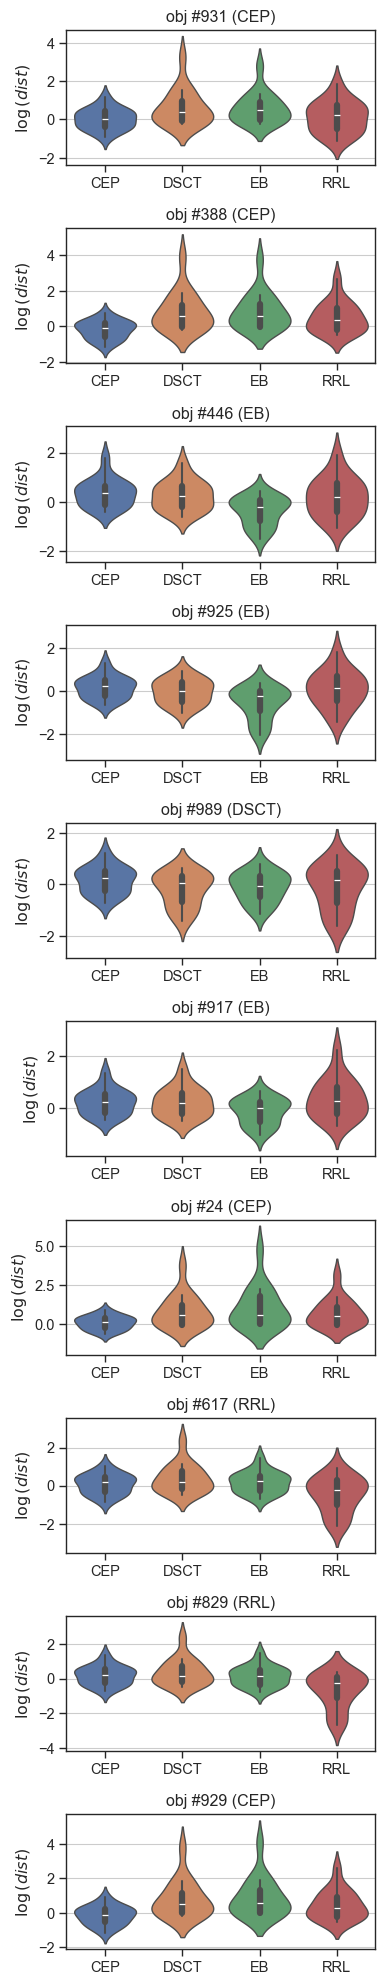

In [33]:
## DELETE?

fig, axs = plt.subplots(10, 1, figsize=(4, 20))
axs = axs.ravel()
for i, objnum in enumerate(np.random.randint(1000,size=10)):
    sns.violinplot(data=pd.DataFrame(np.log10(dist_df_arr[objnum] + epsilon).T, columns=clusters),ax=axs[i])
    plt.title(f'Distribution of log10 distances for object {objnum}')
    axs[i].set_ylabel(r"$\log{(dist)}$")
    axs[i].set_title(f"obj #{objnum} ({y_df.iloc[objnum]})")
plt.tight_layout()
plt.show()

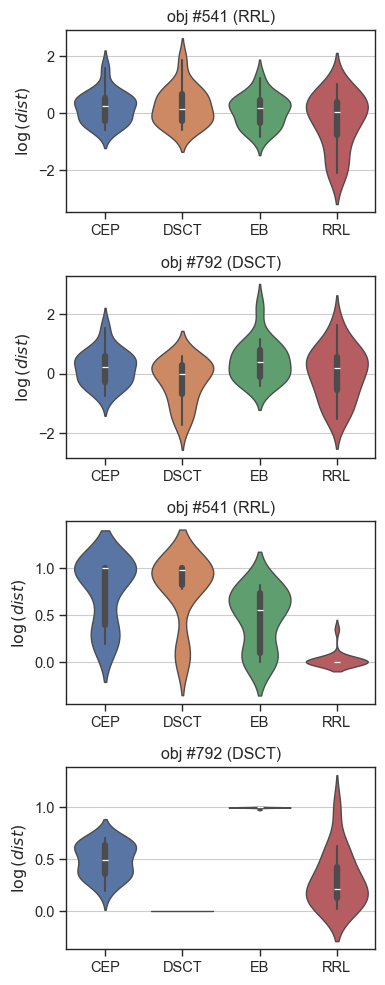

In [34]:
fig, axs = plt.subplots(4, 1, figsize=(4, 10))
axs = axs.ravel()
for i, objnum in enumerate([541, 792]):
    sns.violinplot(data=pd.DataFrame(np.log10(dist_df_arr[objnum] + epsilon).T, columns=clusters),ax=axs[i])
    plt.title(f'Distribution of log10 distances for object {objnum}')
    axs[i].set_ylabel(r"$\log{(dist)}$")
    axs[i].set_title(f"obj #{objnum} ({y_df.iloc[objnum]})")
for i, objnum in enumerate([541, 792]):
    sns.violinplot(data=pd.DataFrame(scaled_dist_df_arr[objnum].T, columns=clusters),ax=axs[i+2])
    plt.title(f'Distribution of log10 distances for object {objnum}')
    axs[i+2].set_ylabel(r"$\log{(dist)}$")
    axs[i+2].set_title(f"obj #{objnum} ({y_df.iloc[objnum]})")
plt.tight_layout()
plt.show()

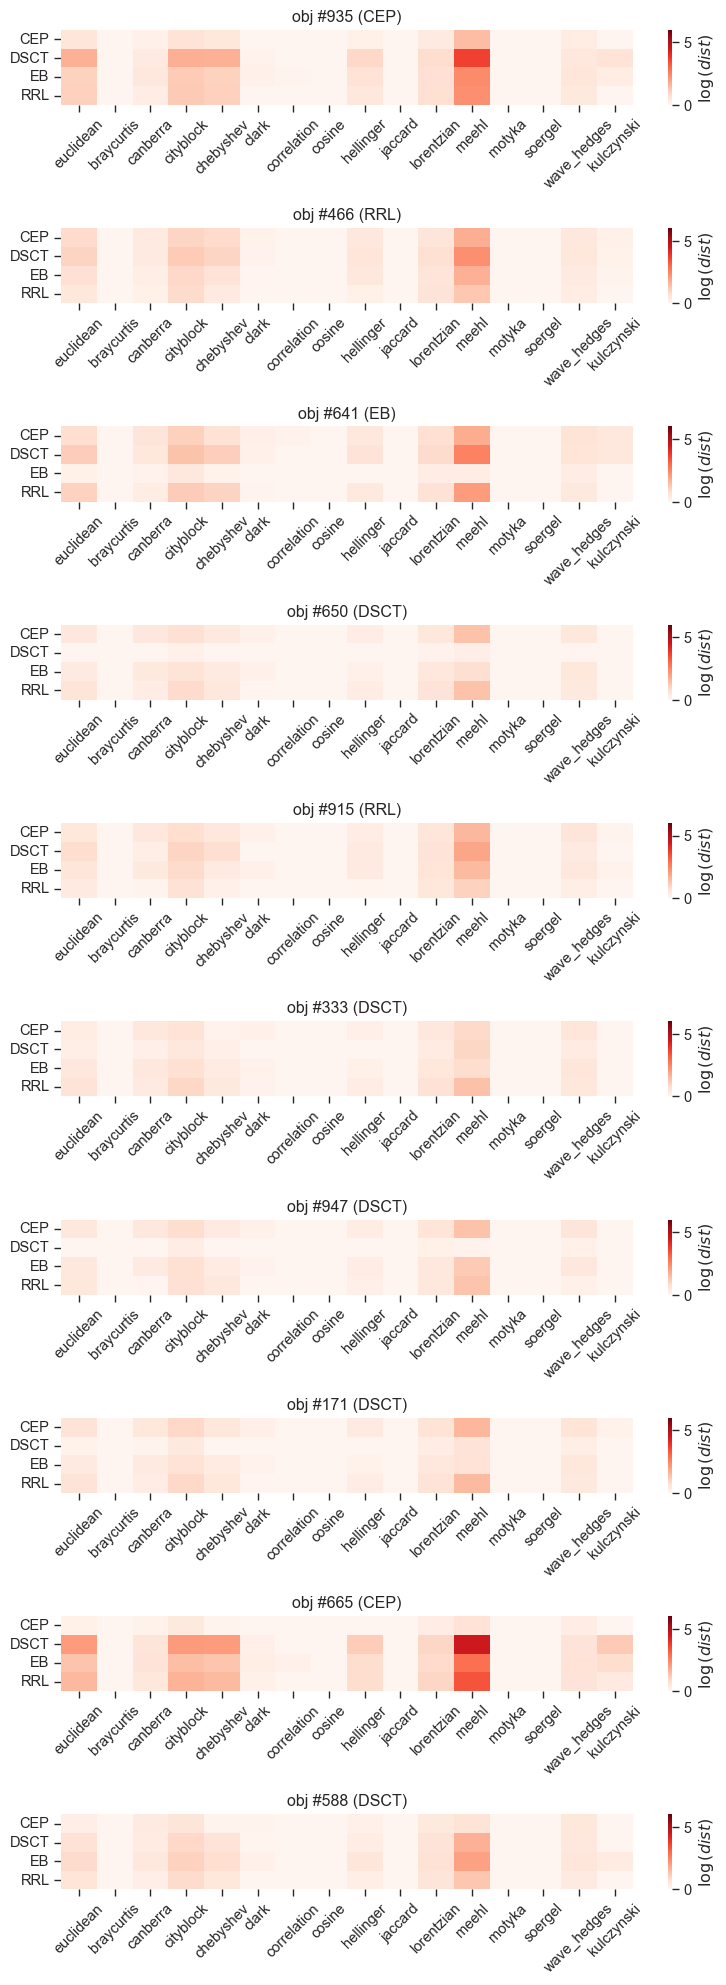

In [35]:
## DELETE?

fig, axs = plt.subplots(10, 1, figsize=(8, 20))
axs = axs.ravel()
for i, objnum in enumerate(np.random.randint(1000,size=10)):
    sns.heatmap(pd.DataFrame(np.log10(dist_df_arr[objnum] + epsilon), index=clusters, columns=unique_metrics),cmap="Reds",ax=axs[i],
                vmin=0, vmax=6, cbar_kws={'label': r"$\log{(dist)}$"})
    axs[i].set_title(f"obj #{objnum} ({y_df.iloc[objnum]})")
    axs[i].tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()

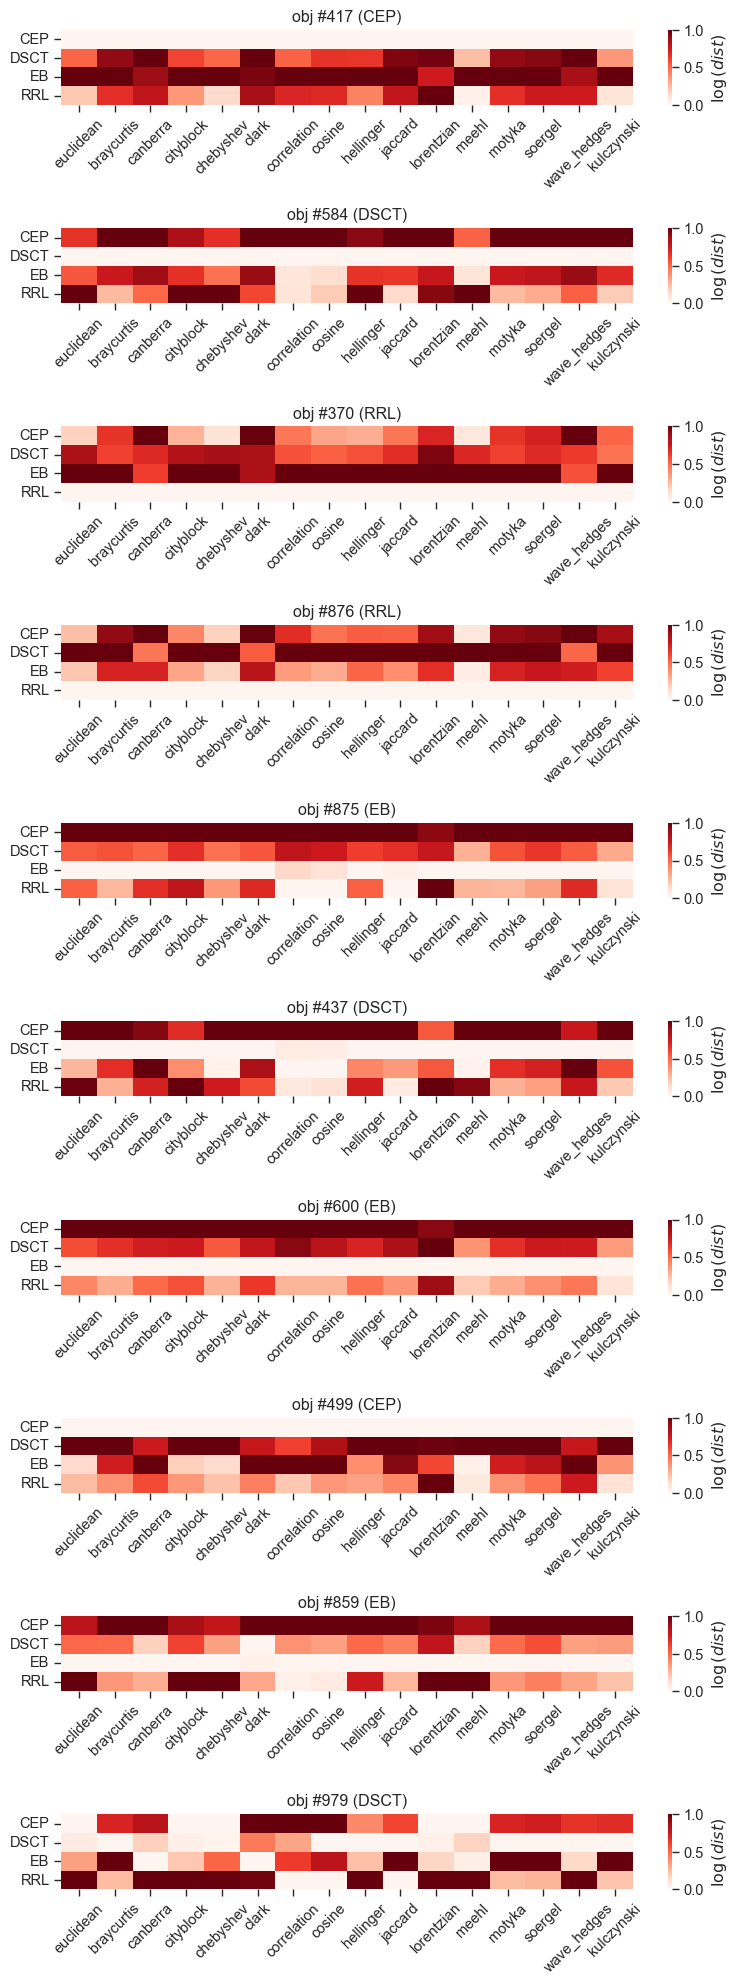

In [36]:
## DELETE?

fig, axs = plt.subplots(10, 1, figsize=(8, 20))
axs = axs.ravel()
for i, objnum in enumerate(np.random.randint(1000,size=10)):
    sns.heatmap(pd.DataFrame(scaled_dist_df_arr[objnum], index=clusters, columns=unique_metrics),cmap="Reds",ax=axs[i],
                vmin=0, vmax=1, cbar_kws={'label': r"$\log{(dist)}$"})
    axs[i].set_title(f"obj #{objnum} ({y_df.iloc[objnum]})")
    axs[i].tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()

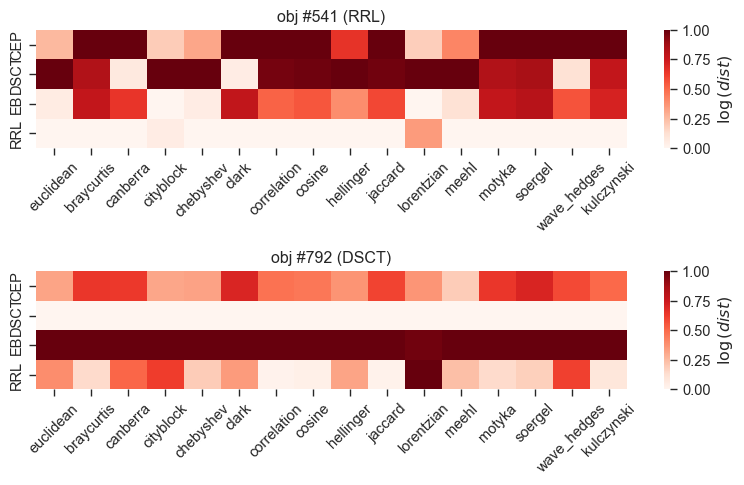

In [37]:
## DELETE?

fig, axs = plt.subplots(2, 1, figsize=(8, 5))
axs = axs.ravel()
for i, objnum in enumerate([541, 792]):
    sns.heatmap(pd.DataFrame(scaled_dist_df_arr[objnum], index=clusters, columns=unique_metrics),cmap="Reds",ax=axs[i],
                vmin=0, vmax=1, cbar_kws={'label': r"$\log{(dist)}$"})
    axs[i].set_title(f"obj #{objnum} ({y_df.iloc[objnum]})")
    axs[i].tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()

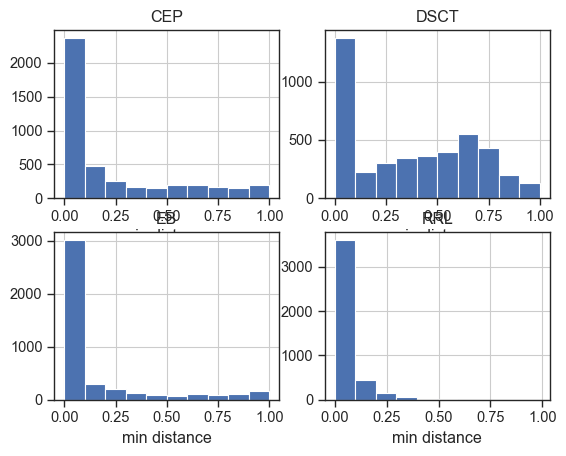

In [38]:
## DELETE?

fig, ax = plt.subplots(2,2)
ax = ax.ravel()
_ = np.percentile(scaled_dist_df_arr, [0], axis=-1).squeeze()
for i,c in enumerate(clusters):
  ax[i].hist(_[:,i])
  ax[i].set_title(c)
  ax[i].set_xlabel("min distance")

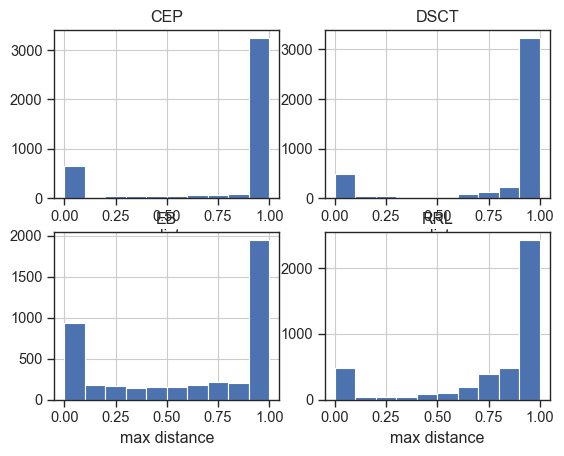

In [39]:
fig, ax = plt.subplots(2,2)
ax = ax.ravel()
_ = np.percentile(scaled_dist_df_arr, [100], axis=-1).squeeze()
#_ = np.median(dist_df_arr, axis=-1).squeeze()

for i,c in enumerate(clusters):
  ax[i].hist(_[:,i])
  ax[i].set_title(c)
  ax[i].set_xlabel("max distance")

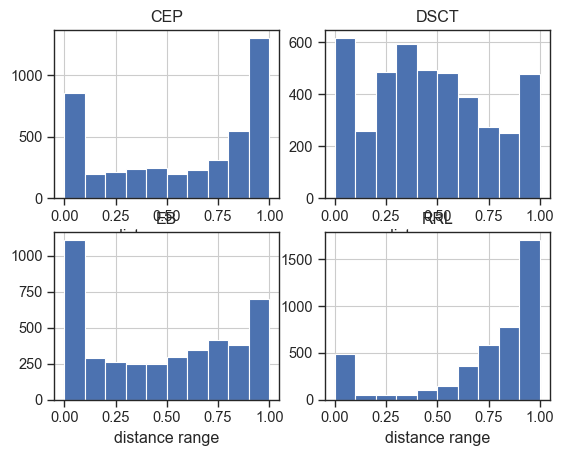

In [40]:
fig, ax = plt.subplots(2,2)
ax = ax.ravel()
_ = np.percentile(scaled_dist_df_arr, [100], axis=-1).squeeze() - np.percentile(scaled_dist_df_arr, [0], axis=-1).squeeze()
#_ = np.median(dist_df_arr, axis=-1).squeeze()

for i,c in enumerate(clusters):
  ax[i].hist(_[:,i])
  ax[i].set_title(c)
  ax[i].set_xlabel("distance range")

In [41]:
for metric in tqdm(unique_metrics, desc="Metric", leave=True):
    metric_str = utils.get_metric_name(metric)
    dist_df = scaled_dist_df_dict[metric_str]

    dist_df['minimum_distance'] = dist_df.min(axis=1)
    dist_df['median_distance'] = dist_df.median(axis=1)

    scaled_dist_df_dict[metric_str] = dist_df

Metric:   0%|          | 0/16 [00:00<?, ?it/s]

In [42]:
cluster_aggregates = ["min", "median"]
metric_aggregates = ["min", "p25", "median"]

In [43]:
dist_aggregates = np.zeros((len(dist_df_dict["Euclidean"]), 3, 2))
dist_aggregates.shape

(4318, 3, 2)

In [44]:
scaled_dist_df_dict[utils.get_metric_name(metric)]

,CEP_dist,DSCT_dist,EB_dist,RRL_dist,minimum_distance,median_distance
0,0.096544,1.000000e+00,1.192093e-07,6.786129e-02,1.192093e-07,0.067861
1,1.000000,1.192093e-07,8.232247e-01,3.349211e-01,1.192093e-07,0.334921
2,0.881082,1.192093e-07,1.000000e+00,3.458006e-01,1.192093e-07,0.345801
3,0.968711,6.749072e-02,1.000000e+00,1.192093e-07,1.192093e-07,0.067491
4,0.917994,1.000000e+00,1.192093e-07,9.860986e-01,1.192093e-07,0.917994
...,...,...,...,...,...,...
4313,1.000000,3.948205e-01,1.192093e-07,5.039088e-01,1.192093e-07,0.394820
4314,1.000000,8.818506e-01,3.572324e-01,1.192093e-07,1.192093e-07,0.357232
4315,1.000000,3.139776e-01,1.192093e-07,2.426612e-01,1.192093e-07,0.242661
4316,1.000000,1.422514e-01,5.348724e-02,1.192093e-07,1.192093e-07,0.053487


In [45]:
dist_minK_by_M = np.array([dist_df_dict[utils.get_metric_name(metric)]["minimum_distance"]
                           for i,metric in enumerate(unique_metrics)])
dist_medK_by_M = np.array([dist_df_dict[utils.get_metric_name(metric)]["median_distance"]
                           for i,metric in enumerate(unique_metrics)])
scaled_dist_minK_by_M = np.array([scaled_dist_df_dict[utils.get_metric_name(metric)]["minimum_distance"]
                           for i,metric in enumerate(unique_metrics)])
scaled_dist_medK_by_M = np.array([scaled_dist_df_dict[utils.get_metric_name(metric)]["median_distance"]
                           for i,metric in enumerate(unique_metrics)])

In [46]:
# dist_aggregates = pd.DataFrame(
#     np.concatenate(
#         [
#             np.percentile(dist_minK_by_M, [0, 0.25, 0.5], axis=0),
#             np.percentile(dist_medK_by_M, [0, 0.25, 0.5], axis=0),
#         ]
#     ).T,
#     columns=[k + m for k in ["min", "med"] for m in ["min", "25th", "med"]],
#     index=df.index,
# )

# dist_aggregates = pd.concat([dist_aggregates,df],axis=1).drop(["quartile_if1", "quartile_if2", "quartile_if3"],axis=1)
# dist_aggregates

In [47]:
np.concatenate(np.percentile(dist_minK_by_M, [0,0.25,0.5], axis=0)).T.shape

(12954,)

In [48]:
assert (ranksIDdfs[0].index == X_df.index).all()

## THIS IS THE REASON WHY I REMOVED SORTING FROM IF FUNCTION

In [49]:
dist_aggregates = pd.DataFrame(np.concatenate(
    [np.percentile(dist_minK_by_M, [0,0.25,0.5], axis=0), #metric percentiles on the min of clusters
    np.percentile(dist_medK_by_M, [0,0.25,0.5], axis=0), #metric percentiles on the median of clusters
     #np.percentile(scaled_dist_minK_by_M, [0,0.25,0.5], axis=0), #metric percentiles on the scaled min of clusters
     np.percentile(scaled_dist_medK_by_M, [0,0.25,0.5], axis=0), #metric percentiles on the scaled med of clusters
    ]).T,
                               columns=[k+m for k in ["min", "med"] for m in ["min", "25th", "med"]] +
     [k+m for k in ["scaledmed"] for m in ["min", "25th", "med"]],
                              index=X_df.index)

dist_aggregates = pd.concat([dist_aggregates,df],axis=1).drop(["quartile_if1", "quartile_if2", "quartile_if3"],axis=1)
dist_aggregates

,minmin,min25th,minmed,medmin,med25th,medmed,scaledmedmin,scaledmed25th,scaledmedmed,if1,if2,if3,class
snid,,,,,,,,,,,,,
93852051,0.016655,0.017370,0.018085,0.068188,0.070155,0.072123,0.008406,0.009775,0.011143,-0.068849,-0.071211,-0.046096,EB
133953454,0.010289,0.010604,0.010920,0.027755,0.027920,0.028085,0.062334,0.065960,0.069586,-0.055542,-0.054078,-0.056086,DSCT
156704754,0.009076,0.009420,0.009763,0.037566,0.038346,0.039125,0.145210,0.147522,0.149835,-0.029540,-0.041390,-0.058449,DSCT
94869465,0.028378,0.028476,0.028574,0.101931,0.104499,0.107067,0.067491,0.068798,0.070105,-0.024997,-0.017251,-0.030555,DSCT
143158599,0.016810,0.017288,0.017767,0.020444,0.020834,0.021225,0.003151,0.004046,0.004941,-0.031106,-0.036637,-0.025699,EB
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69018019,0.204525,0.207504,0.210484,0.581641,0.583107,0.584574,0.363477,0.364652,0.365828,0.038510,0.046227,0.034200,dwarf-nova
97601275,0.064405,0.066193,0.067981,0.207490,0.215244,0.222997,0.009174,0.010937,0.012699,0.023298,0.026593,0.048065,dwarf-nova
97897233,0.212789,0.217499,0.222210,0.540477,0.541593,0.542708,0.236002,0.236252,0.236502,0.068889,0.073125,0.063602,dwarf-nova


In [50]:
dist_aggregates_ranks = (
    dist_aggregates[['minmin', 'min25th', 'minmed', 'medmin', 'med25th', 'medmed', 'if1',
       'if2', 'if3']].rank(axis=0, ascending=False).astype(int)
)
dist_aggregates_ranks

,minmin,min25th,minmed,medmin,med25th,medmed,if1,if2,if3
snid,,,,,,,,,
93852051,3007,3003,2992,3272,3279,3285,4201,4278,3580
133953454,3370,3372,3374,4015,4030,4050,3953,4047,3871
156704754,3470,3464,3459,3735,3743,3754,3073,3668,3923
94869465,2470,2503,2532,2876,2885,2894,2946,2780,3113
143158599,3001,3005,3010,4245,4248,4248,3133,3483,2989
...,...,...,...,...,...,...,...,...,...
69018019,732,740,742,362,365,365,1044,771,1373
97601275,1683,1691,1702,1886,1858,1837,1481,1382,951
97897233,699,698,699,491,497,502,386,270,565


In [51]:
dist_aggregates_ranks.sort_values(by="if2", ascending=False)

,minmin,min25th,minmed,medmin,med25th,medmed,if1,if2,if3
snid,,,,,,,,,
13873224,3973,3971,3969,2527,2533,2544,4197,4318,4290
10552144,3061,3066,3070,4255,4256,4254,4243,4317,4283
1283805,4168,4168,4169,2835,2837,2830,4275,4316,4192
53358169,4095,4096,4097,3135,3125,3115,4211,4315,4163
25574309,4221,4220,4219,3541,3531,3524,4311,4314,4312
...,...,...,...,...,...,...,...,...,...
125103424,99,99,98,26,24,22,4,5,12
92717442,25,24,22,5,5,4,5,4,5
94602724,190,182,175,39,34,30,2,3,2


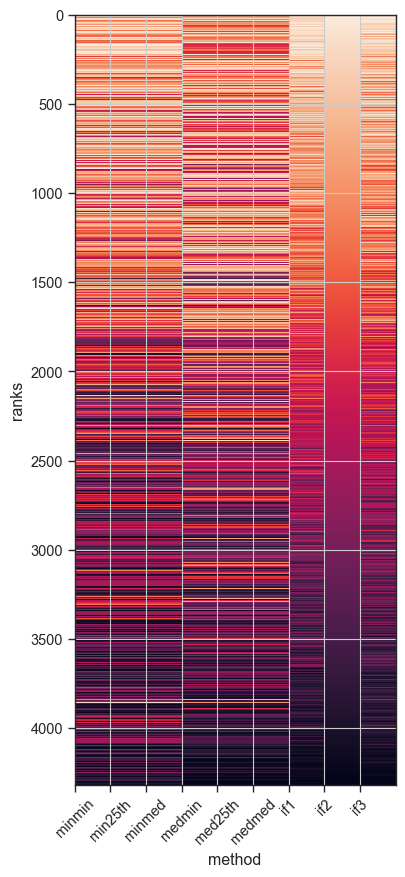

In [52]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(
    dist_aggregates_ranks.sort_values(by="if2", ascending=False), interpolation="none"
)
ax.set_aspect(0.005)
ax.set_xticks(np.arange(-0.5, 8.5), labels=dist_aggregates_ranks.columns, rotation=45)
ax.set_ylabel("ranks")
ax.set_xlabel("method")
ax.grid("off")

In [53]:
dist_aggregates.min()

minmin           0.000165
min25th          0.000169
minmed           0.000174
medmin           0.011095
med25th          0.011355
medmed           0.011446
scaledmedmin          0.0
scaledmed25th     0.00002
scaledmedmed     0.000022
if1              -0.08831
if2             -0.083483
if3             -0.092617
class                 AGN
dtype: object

/Users/sidchaini/miniconda3/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


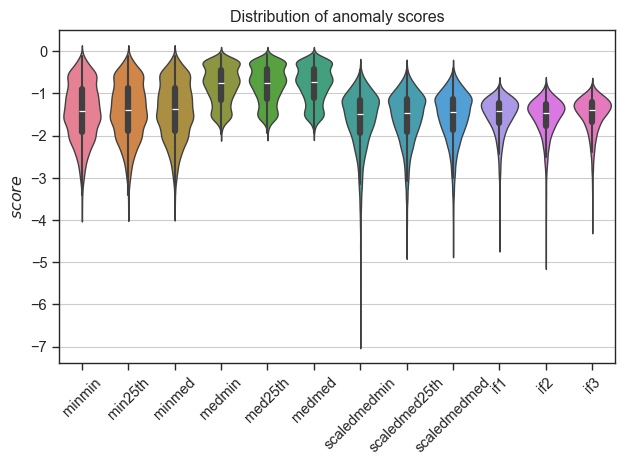

In [54]:
sns.violinplot(
    data=np.log10(dist_aggregates.drop("class",axis=1))
)
plt.title(f"Distribution of anomaly scores")
plt.ylabel(r"$score$")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [55]:
df = dist_aggregates

In [56]:
df.sort_values("if2",ascending=False).iloc[:20]

,minmin,min25th,minmed,medmin,med25th,medmed,scaledmedmin,scaledmed25th,scaledmedmed,if1,if2,if3,class
snid,,,,,,,,,,,,,
96837672,0.524844,0.530075,0.535306,0.725470,0.734108,0.742747,0.018846,0.021258,0.023669,0.153602,0.155124,0.154811,CEP
34882116,0.502568,0.505085,0.507601,0.719989,0.726740,0.733491,0.070063,0.071069,0.072074,0.140443,0.153602,0.150165,CEP
94602724,0.392684,0.398468,0.404252,0.716352,0.723950,0.731548,0.021441,0.024665,0.027890,0.151189,0.152706,0.151189,CEP
92717442,0.615692,0.618393,0.621094,0.811991,0.817535,0.823079,0.003656,0.005896,0.008136,0.142569,0.149095,0.140373,CEP
125103424,0.517682,0.519754,0.521826,0.733617,0.741558,0.749499,0.016249,0.018720,0.021192,0.144949,0.147896,0.131143,CEP
83406315,0.519896,0.521581,0.523266,0.793398,0.798664,0.803930,0.003867,0.006099,0.008331,0.128089,0.143122,0.129563,CEP
132356710,0.298418,0.301491,0.304563,0.703075,0.708009,0.712944,0.020343,0.022733,0.025124,0.118630,0.141934,0.109123,CEP
59245585,0.429654,0.433329,0.437005,0.717416,0.721812,0.726209,0.071174,0.071539,0.071905,0.123838,0.140197,0.134723,CEP
108559610,0.289966,0.295964,0.301962,0.709159,0.712365,0.715571,0.022258,0.023506,0.024753,0.117724,0.138254,0.141980,CEP


In [57]:
df.sort_values("medmed",ascending=False).iloc[:20]

,minmin,min25th,minmed,medmin,med25th,medmed,scaledmedmin,scaledmed25th,scaledmedmed,if1,if2,if3,class
snid,,,,,,,,,,,,,
50610308,0.444243,0.448872,0.453501,0.857131,0.858411,0.859691,0.003418,0.004641,0.005865,0.076815,0.075586,0.072786,CEP
91170406,0.632044,0.632508,0.632973,0.829542,0.830873,0.832203,0.003238,0.004621,0.006004,0.103774,0.124416,0.097899,PISN-STELLA_HECORE
152565269,0.311507,0.317303,0.323100,0.828639,0.829623,0.830608,0.003699,0.004895,0.006090,0.075118,0.075170,0.064149,uLens-Binary
92717442,0.615692,0.618393,0.621094,0.811991,0.817535,0.823079,0.003656,0.005896,0.008136,0.142569,0.149095,0.140373,CEP
88253880,0.772094,0.774938,0.777782,0.817486,0.818667,0.819848,0.002901,0.003120,0.003339,0.146843,0.119747,0.129081,SNIa-91bg
83406315,0.519896,0.521581,0.523266,0.793398,0.798664,0.803930,0.003867,0.006099,0.008331,0.128089,0.143122,0.129563,CEP
130307557,0.590554,0.592339,0.594124,0.790761,0.796645,0.802529,0.004111,0.006334,0.008556,0.140443,0.133194,0.139015,CEP
140819459,0.700631,0.701320,0.702008,0.791081,0.792293,0.793506,0.175221,0.180475,0.185730,0.103121,0.076347,0.109615,dwarf-nova
1067946,0.310913,0.311546,0.312180,0.769761,0.772123,0.774486,0.003618,0.005038,0.006458,0.097046,0.063838,0.078952,CEP


In [58]:
df.sort_values("med25th",ascending=False)

,minmin,min25th,minmed,medmin,med25th,medmed,scaledmedmin,scaledmed25th,scaledmedmed,if1,if2,if3,class
snid,,,,,,,,,,,,,
50610308,0.444243,0.448872,0.453501,0.857131,0.858411,0.859691,0.003418,0.004641,0.005865,0.076815,0.075586,0.072786,CEP
91170406,0.632044,0.632508,0.632973,0.829542,0.830873,0.832203,0.003238,0.004621,0.006004,0.103774,0.124416,0.097899,PISN-STELLA_HECORE
152565269,0.311507,0.317303,0.323100,0.828639,0.829623,0.830608,0.003699,0.004895,0.006090,0.075118,0.075170,0.064149,uLens-Binary
88253880,0.772094,0.774938,0.777782,0.817486,0.818667,0.819848,0.002901,0.003120,0.003339,0.146843,0.119747,0.129081,SNIa-91bg
92717442,0.615692,0.618393,0.621094,0.811991,0.817535,0.823079,0.003656,0.005896,0.008136,0.142569,0.149095,0.140373,CEP
...,...,...,...,...,...,...,...,...,...,...,...,...,...
128890507,0.009598,0.009751,0.009903,0.012617,0.012983,0.013349,0.018586,0.018704,0.018822,-0.017540,-0.002020,-0.033250,DSCT
107777829,0.010531,0.010676,0.010822,0.011371,0.011794,0.012218,0.002584,0.002935,0.003286,-0.057040,-0.056953,-0.039475,EB
140260087,0.010477,0.010626,0.010776,0.011280,0.011790,0.012300,0.003888,0.003918,0.003949,-0.033110,-0.034321,-0.053837,DSCT


In [67]:
df.sort_values("minmed",ascending=False).iloc[:20]

,minmin,min25th,minmed,medmin,med25th,medmed,scaledmedmin,scaledmed25th,scaledmedmed,if1,if2,if3,class,status
snid,,,,,,,,,,,,,,
88253880,0.772094,0.774938,0.777782,0.817486,0.818667,0.819848,0.002901,0.003120,0.003339,0.146843,0.119747,0.129081,SNIa-91bg,anomalous
141445943,0.708816,0.708842,0.708867,0.736282,0.738020,0.739758,0.017491,0.017554,0.017616,0.087990,0.097802,0.100344,ILOT,anomalous
37734415,0.703729,0.706049,0.708370,0.709919,0.713442,0.716965,0.007455,0.008233,0.009011,0.133194,0.110279,0.114309,dwarf-nova,anomalous
140819459,0.700631,0.701320,0.702008,0.791081,0.792293,0.793506,0.175221,0.180475,0.185730,0.103121,0.076347,0.109615,dwarf-nova,anomalous
118315745,0.695961,0.696131,0.696301,0.758498,0.759856,0.761215,0.014560,0.015570,0.016580,0.114207,0.111778,0.125909,uLens-Single-GenLens,anomalous
114522598,0.683073,0.683463,0.683853,0.769395,0.771519,0.773644,0.082230,0.084641,0.087051,0.113644,0.112742,0.134063,uLens-Single-GenLens,anomalous
103313063,0.679649,0.681714,0.683778,0.682937,0.686510,0.690083,0.005362,0.005744,0.006127,0.098283,0.087167,0.095813,SNIa-91bg,anomalous
99141506,0.675586,0.676646,0.677705,0.720873,0.722699,0.724525,0.014199,0.014330,0.014461,0.095781,0.088798,0.097964,dwarf-nova,anomalous
43265685,0.671533,0.671927,0.672321,0.724747,0.725552,0.726356,0.084979,0.085456,0.085934,0.092096,0.083064,0.086904,PISN-STELLA_HYDROGENIC,anomalous


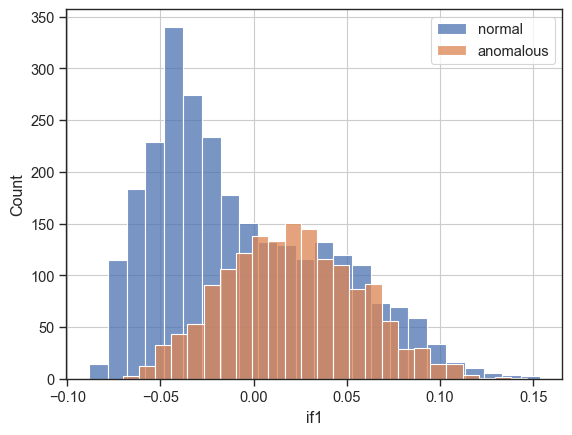

In [60]:
sns.histplot(df[df["class"].isin(["CEP",
"DSCT",
"EB",
"RRL",]
)]["if1"], label="normal")

sns.histplot(df[~df["class"].isin(["CEP",
"DSCT",
"EB",
"RRL",]
)]["if1"],label="anomalous")

plt.legend()
plt.show()

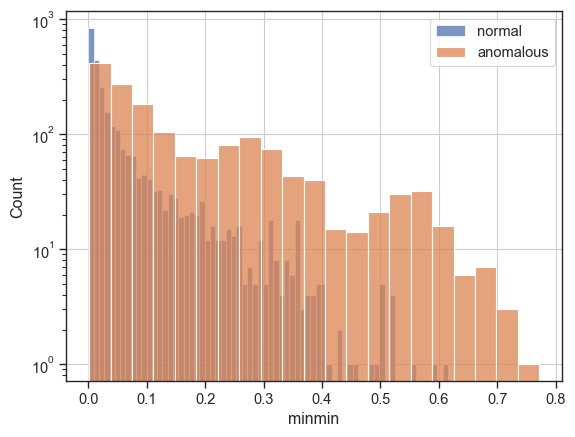

In [61]:
sns.histplot(df[df["class"].isin(["CEP",
"DSCT",
"EB",
"RRL",]
)]["minmin"], label="normal")

sns.histplot(df[~df["class"].isin(["CEP",
"DSCT",
"EB",
"RRL",]
)]["minmin"],label="anomalous")
plt.yscale("log")
plt.legend()
plt.show()

In [62]:
# anom_classes = ['SNIa-91bg', 'SNII-Templates', 'dwarf-nova', 'Mdwarf-flare',
#        'uLens-Single-GenLens', 'CART', 'SNIb+HostXT_V19',
#        'uLens-Single_PyLIMA', 'SNIIn-MOSFIT', 'uLens-Binary', 'ILOT',
#        'SNIcBL+HostXT_V19', 'SNIIn+HostXT_V19', 'EB',
#        'PISN-STELLA_HECORE', 'SNIc-Templates', 'PISN-STELLA_HYDROGENIC',
#        'PISN-MOSFIT', 'SNIb-Templates', 
#        'SNII+HostXT_V19', 'SNIax', 'TDE', 'SLSN-I_no_host', 'SLSN-I+host',
#        'SNIa-SALT3', 'SNIc+HostXT_V19', 'KN_K17', 'SL-SN1a', 'KN_B19',
#        'SL-SNIb', 'SNIIb+HostXT_V19', 'SNII-NMF', 'SL-SNII', 'AGN', 'RRL',
#        'SL-SNIc'], dtype=object)


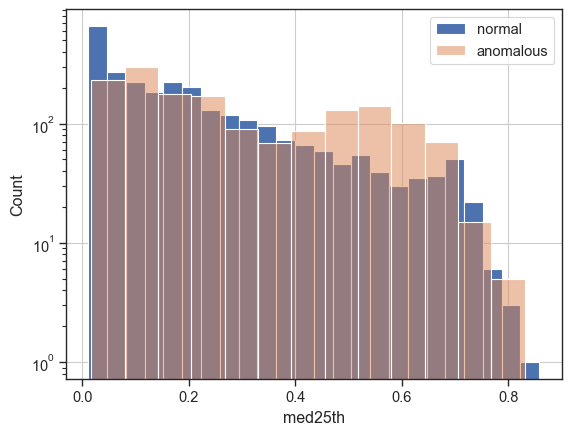

In [63]:
method = "med25th"

sns.histplot(df[df["class"].isin(["CEP",
"DSCT",
"EB",
"RRL",]
)][method], label="normal", alpha=1)

sns.histplot(df[~df["class"].isin(["CEP",
"DSCT",
"EB",
"RRL",]
)][method],label="anomalous", alpha=0.5)

plt.yscale("log")
plt.legend()
plt.show()

In [64]:
normal_classes = ["CEP", "DSCT", "EB", "RRL"]
df['status'] = df['class'].apply(lambda x: 'normal' if x in normal_classes else 'anomalous')

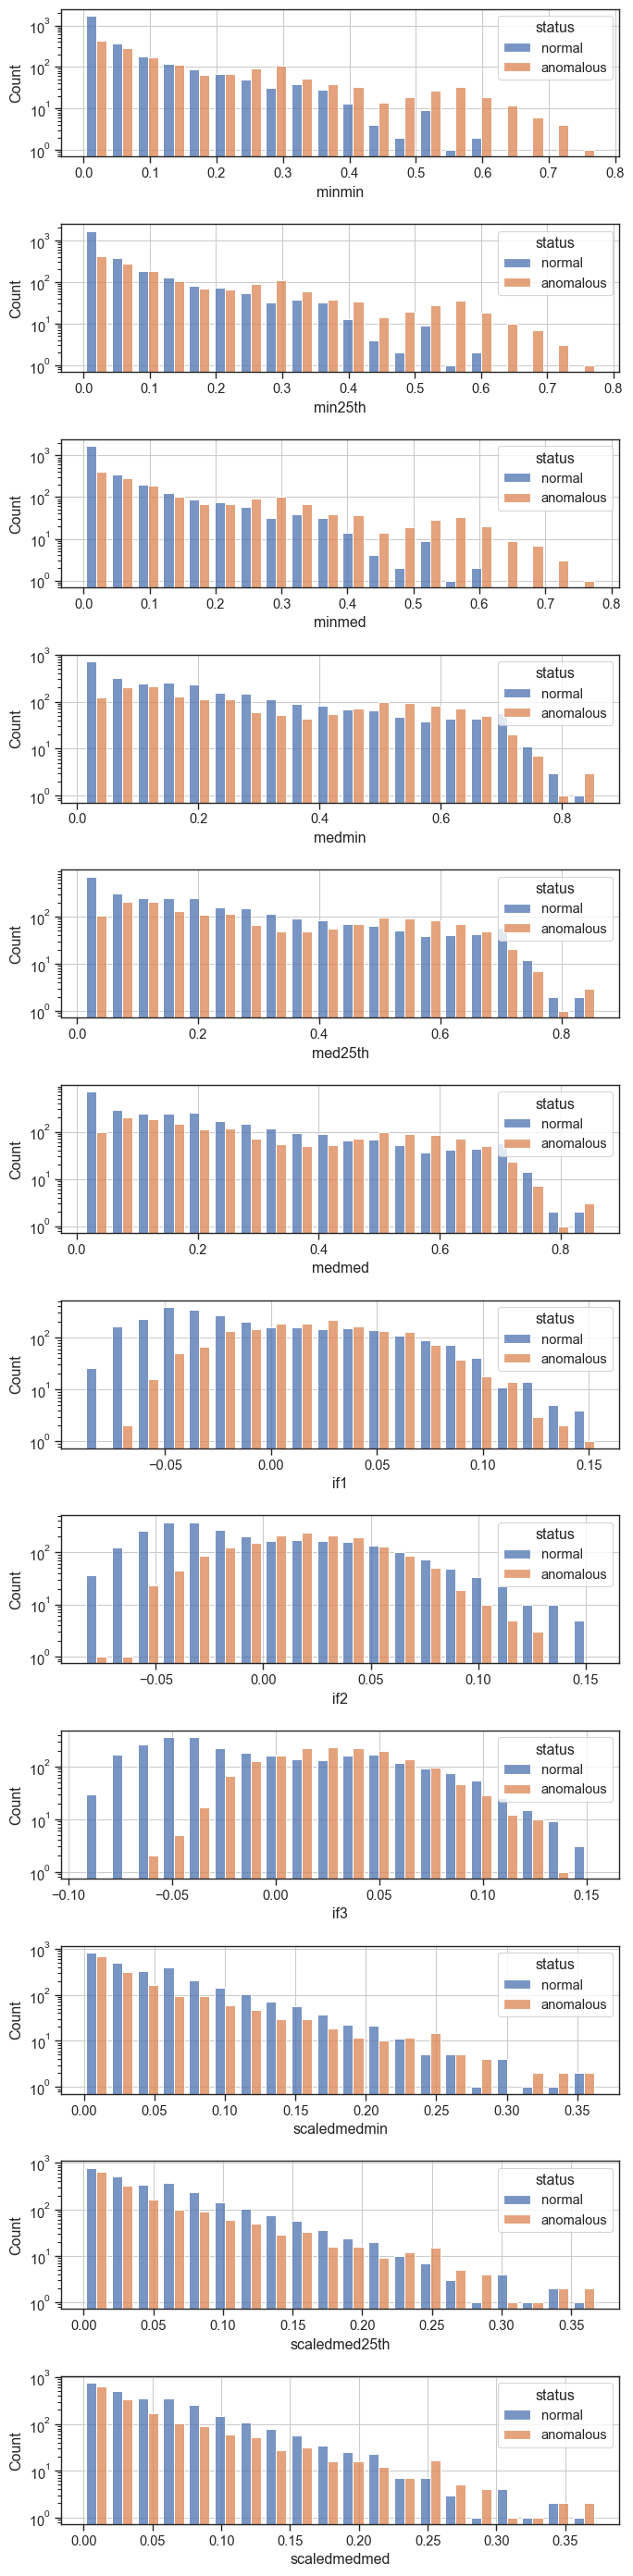

In [65]:
all_methods=["minmin", "min25th", "minmed", "medmin", "med25th", "medmed", "if1", "if2", "if3", "scaledmedmin", "scaledmed25th", "scaledmedmed"]
fig, axs = plt.subplots(len(all_methods),1, figsize=(7,7*len(all_methods)//3))
axs = axs.ravel()
for i, method in enumerate(all_methods):
    sns.histplot(data=df, x=method, hue='status', multiple="dodge", shrink=0.8, ax=axs[i],bins=20)
    axs[i].set_yscale("log")
plt.tight_layout()
plt.show()